In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(3680, 24)
(3680, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.23606978,  0.13671124, -0.37990203,  0.2484574 ,
       -0.12517616, -0.37155449, -0.25023079,  0.13091931, -0.37352049,
       -0.26011711, -0.12646298, -0.38600054,  0.01480911, -0.03651889,
       -0.02087145,  0.00348074,  1.        ,  0.        ])

In [9]:
Y_motion_RR_swinging[0, :]

array([ 0.00991155, -0.0120281 ,  0.0073788 , -0.0035257 ])

### Linear Regression

In [22]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               #X_motion_RR_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9509886488575962
RMSE:  0.0340123720499214
The lowest error is:  0.00019317672285623644
The highest error is:  0.42228174521953465
The avg. error is:  0.018593155927485776


In [23]:
model_rr_relative_swinging_x.coef_

array([[ 9.51593966e-02, -7.77156117e-16, -7.77156117e-16,
         2.25742902e-01,  0.00000000e+00, -2.22044605e-16,
         9.13961028e-01, -1.13946763e+00,  1.44831005e+00,
         4.28673894e-01, -1.26458250e+00, -2.15911001e-01,
        -2.93608838e+00,  5.60026359e-01]])

In [24]:
model_rr_relative_swinging_x.intercept_

array([-1.34211109])

Text(0, 0.5, 'Predictions')

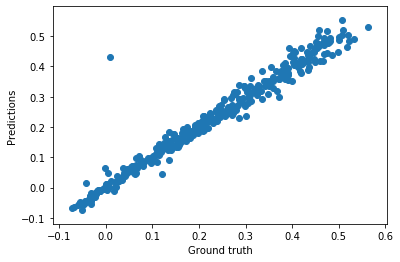

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [25]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               #X_motion_RR_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.36211317965853285
RMSE:  0.00899329914119397
The lowest error is:  2.0058834657721292e-05
The highest error is:  0.07367971487417163
The avg. error is:  0.005547783293833791


In [26]:
model_rr_relative_swinging_y.coef_

array([[ 9.89207881e-03, -2.88289358e-16, -2.22044605e-16,
         1.19624483e-02,  3.33066907e-16,  0.00000000e+00,
         3.82879365e-01, -5.92260792e-01,  4.44359062e-01,
         5.90540711e-01, -6.24888288e-01,  2.51350717e-01,
        -6.05902362e-01, -1.17589526e+00]])

In [27]:
model_rr_relative_swinging_y.intercept_

array([-0.54626765])

Text(0, 0.5, 'Predictions')

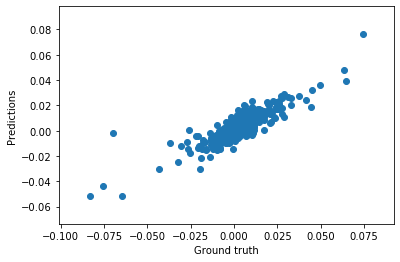

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')